# Discovery Metrics with Uncertainties

The next step is to incorporate uncertainties into our light curves (eventually this will actually involve some detailed calculations, but for now we will use a relatively simplified procedure). The way to determine the uncertainties on a single photometric observation is laid out in Section 3.5 of the LSST definition paper (Ivezic et al. 2008) - note this paper is super long and I recommend only looking at Sec 3.5 for now.

$1$. Eqn 3.1 says the uncertainty is defined as sigma_1^2 = sigma_sys^2 + sigma_rand^2, where the two terms correspond to systematic and random errors. As a side note - for bright sources systematic uncertainties are all that matters, while for faint sources random errors are all that matters. We will adopt sigma_sys = 0.005 mag, as suggested by Ivezic. 

$2$. Calculating sigma_rand is more complicated (Egn 3.2) as we need to know a gamma term (given in Table 3.2) and to calculate m_5, which in turn depends on many other factors. Eventually we will incorporate all of those factors for every observation, but for now we will simply assume that all observations are taken at the meridian (i.e. X = 1). We also assume t_vis = 30 sec. These two assumptions mean the last two terms in Eqn 3.3. are equal to zero, and therefore m_5 will be different in each filter but it can be easily calculated.

$3$. Now we need to simulate an observation, which involves the following steps: 

    i. From the model get the true value of the mag (m_true) for the source and use this to calculate sigma_rand
        
    ii. Use the numpy random module to to select a random number from a gaussian (np.random.normal) with mean m_true and standard deviation sigma_rand - this value is the observed brightness m_obs
    
    iii. Now that we have the magnitude that LSST observes, we need to recalculate sigma_rand (this time using m_obs instead of m_true)
    
    iv. Combine sigma_rand and sigma_sys in order to get sigma_1. This is the uncertainty on your observation.
    

$4$. This procedure then needs to be repeated for all observations. 

$5$. Finally, for our "detection metrics" (i.e. u - z > 0.5 mag) we need to set a significance threshold. What I mean here is that we need to detect a red color, but we need to detect it at 1 sigma, or 2 sigma, or 3 sigma or whatever. I think for now we should be really stringent and require a 3 sigma detection. To calculate the error on u -z, sigma_uz, you can use the following calculation: 

sigma_uz = sqrt( sigma_u^2 + sigma_z^2 )

In cases where u - z / sigma_uz < 3 we do not detect the kilonova, even if u - z > 0.5 mag. 

I would like for you to incorporate these uncertainties into the models and then remake the efficiency plots that you have previously made. 

In [1]:
#Necessary files needed for plotting the curves and manipulating the data.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astropy as astro
from astropy.table import Table,Column
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"] = (10,8)

#We will need to grab the data from where it is saved on the computer.

#NS-NS
APR1215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1215.txt')
APR1314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1314.txt')
H41215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1215.txt')
H41314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1314.txt')
Sly135 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/Sly-135.txt')

#NS-BH
APR4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4Q3a75.txt')
H4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4Q3a75.txt')
MS1Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q3a75.txt')
MS1Q7a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q7a75.txt')

In [2]:
# Constants:
title = 22
subtitle = 20
axis = 16
ticksize = 12
legend = 12

redshift = 0.015


#Convert Absolute Magnitude to Apparent Magnitude

#app_mag: Merger Number -> Merger
#Converts the merger data from absolute magnitude to apparent magnitude.
def app_mag(merger, redshift):
    merger['u']=app_mag_band(merger['u'],redshift)
    merger['g']=app_mag_band(merger['g'],redshift)
    merger['r']=app_mag_band(merger['r'],redshift)
    merger['i']=app_mag_band(merger['i'],redshift)
    merger['z']=app_mag_band(merger['z'],redshift)
    return merger

#app_mag_band: ListofNumbers Number -> ListofNumbers
#converts all the absolute magnitudes into apparent magnitudes.
def app_mag_band(data, redshift):
    return 5*np.log10(lumo_dist(redshift)/10)+data

#lumo_dist: Number -> Number
#converts redshift to luminosity distance
def lumo_dist(redshift):
    return cosmo.luminosity_distance(redshift).to(astro.units.pc).value


#NS-NS Conversions:
APR1215_app=app_mag(APR1215, redshift)
APR1314_app=app_mag(APR1314, redshift)
H41215_app=app_mag(H41215, redshift)
H41314_app=app_mag(H41314, redshift)
Sly135_app=app_mag(Sly135, redshift)

#NS-BH Conversions:
APR4Q3a75_app=app_mag(APR4Q3a75, redshift)
H4Q3a75_app=app_mag(H4Q3a75, redshift)
MS1Q3a75_app=app_mag(MS1Q3a75, redshift)
MS1Q7a75_app=app_mag(MS1Q7a75, redshift)

## Light Curves (NS-NS & NS-BH)

In [3]:
#full_plot: Merger String String -> Image
#Takes the data from the Merger and plots the magnitudes and interpolations of each associated
# photometric band as a function of time measured in days.
def full_plot(merger,name):
    fig=plt.figure(figsize=(12,11))
    ax=fig.add_subplot(111)
    abs_plotter1(merger)
    abs_plot_interp(merger)
    LSST_plot(merger)
    ax.axis([0,35,rounded_up(correct_max(merger))+5,(rounded_down(correct_min(merger))-5)])
    ax.tick_params(labelsize=ticksize)
    plt.title("Light Curve of " + name, fontsize=title)
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.xlabel("Time (Days)", fontsize=axis)
    plt.ylabel('Magnitude', fontsize=axis)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    return

#abs_plotter1 Merger -> Image
#Plots the data from the ascii.reads of the merger.
def abs_plotter1(merger):
    plot_band(merger, 'u', '.', 'b')
    plot_band(merger, 'g', '.', 'g')
    plot_band(merger, 'r', '.', 'y')
    plot_band(merger, 'i', '.', 'orange')
    plot_band(merger, 'z', '.', 'r')
    return

#plot_band: Merger String String String -> Image
#Plots the magnitudes of a photometric band in the merger.
def plot_band(merger, band, style, color):
    plt.plot(merger['day'], merger[band], style, color=color, label=band)
    return

#abs_plotter1 Merger -> Image
#Plots the interpolations calculated from data from the ascii.reads of the merger.
def abs_plot_interp(merger):
    plot_interp(merger, 'u', '--', 'b', 0)
    plot_interp(merger, 'g', '--', 'g', 1)
    plot_interp(merger, 'r', '--', 'y', 2)
    plot_interp(merger, 'i', '--', 'orange', 3)
    plot_interp(merger, 'z', '--', 'r', 4)
    return

#plot_interp: Merger String String String Number -> Image
#Plots the interpolation of a photometric band in the merger.
def plot_interp(merger, name, style, color, number):
    plt.plot(day_new(merger, name), interpolate(merger)[number](day_new(merger, name)),
             style, color=color, label=name+' interp.')
    return

#interpolate: Merger-> List of Interpolations
#Provides the necessary interpolation functions of the mergers in each associated photometric bands. 
def interpolate(merger):
    LSST_u=23.9
    LSST_g=25.0
    LSST_r=24.7
    LSST_i=24.0
    LSST_z=23.3
    approx='cubic'
    u=interp1d(merger['day'][np.isfinite(merger['u'])], merger['u'][np.isfinite(merger['u'])],
               kind=approx, bounds_error=False, fill_value=LSST_u)
    g=interp1d(merger['day'][np.isfinite(merger['g'])], merger['g'][np.isfinite(merger['g'])],
               kind=approx, bounds_error=False, fill_value=LSST_g)
    r=interp1d(merger['day'][np.isfinite(merger['r'])], merger['r'][np.isfinite(merger['r'])],
               kind=approx, bounds_error=False, fill_value=LSST_r)
    i=interp1d(merger['day'][np.isfinite(merger['i'])], merger['i'][np.isfinite(merger['i'])],
               kind=approx, bounds_error=False, fill_value=LSST_i)
    z=interp1d(merger['day'][np.isfinite(merger['z'])], merger['z'][np.isfinite(merger['z'])],
               kind=approx, bounds_error=False, fill_value=LSST_z)
    return [u, g, r, i, z]

#day_new Merger String -> List of Numbers
#Produces a new set of points between the range of the 'day' column in the merger data. 
# This is useful for plotting the interpolations.

def day_new(merger, band):
    set_length=100
    day_new = np.linspace(min(merger['day'][np.isfinite(merger[band])]),
                          max(merger['day'][np.isfinite(merger[band])]),set_length)
    return day_new

#LSST_plot: Merger -> Image
#Plots graphs of the LSST's 5-sigma depths in all five bands.
def LSST_plot(merger):
    LSST_u=(merger['day']/merger['day'])-1+23.9
    LSST_g=(merger['day']/merger['day'])-1+25.0
    LSST_r=(merger['day']/merger['day'])-1+24.7
    LSST_i=(merger['day']/merger['day'])-1+24.0
    LSST_z=(merger['day']/merger['day'])-1+23.3
    plt.plot(merger['day'], LSST_u, 'b', label='LSST \n u-band')
    plt.plot(merger['day'], LSST_g, 'g', label='LSST \n g-band')
    plt.plot(merger['day'], LSST_r, 'y', label='LSST \n r-band')
    plt.plot(merger['day'], LSST_i, 'orange', label='LSST \n i-band')
    plt.plot(merger['day'], LSST_z, 'r', label='LSST \n z-band')
    return

#correct_max: Merger -> Number
#Outputs the largest magnitude in the entire merger data.
def correct_max(merger):
    max_list = [max(merger['u'][np.isfinite(merger['u'])]), 
                max(merger['g'][np.isfinite(merger['g'])]), 
                max(merger['r'][np.isfinite(merger['r'])]),
                max(merger['i'][np.isfinite(merger['i'])]),
                max(merger['z'][np.isfinite(merger['z'])])]
    return max(max_list)

#correct_min: Merger -> Number
#Outputs the smallest magnitude in the entire merger data.
def correct_min(merger):
    min_list = [min(merger['u'][np.isfinite(merger['u'])]), 
                min(merger['g'][np.isfinite(merger['g'])]), 
                min(merger['r'][np.isfinite(merger['r'])]),
                min(merger['i'][np.isfinite(merger['i'])]),
                min(merger['z'][np.isfinite(merger['z'])])]
    return min(min_list)

#round_up: number base -> number
#Rounds the number up to the nearest multiple of the base number.
def rounded_up(x, base=5):
    return int(base * (round(float(x)/base)+1))

#round_down: number base -> number
#Rounds the number down to the nearest multiple of the base number.
def rounded_down(x, base=5):
    return int(base * (round(float(x)/base)))

In [4]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

bands=['u','g','r', 'i', 'z']

#rand_plot: Merger String String String -> Image
#Plots a randomly chosen band from the merger.
def band_plot(merger, name):
    LSST_u=(merger['day']/merger['day'])-1+23.9
    LSST_g=(merger['day']/merger['day'])-1+25.0
    LSST_r=(merger['day']/merger['day'])-1+24.7
    LSST_i=(merger['day']/merger['day'])-1+24.0
    LSST_z=(merger['day']/merger['day'])-1+23.3
    fig=plt.figure(figsize=(10,25))
    for band in bands:
        if band == 'u':
            band_graph(merger, 'u', 'b', 511, 0, LSST_u)
        elif band == 'g':
            band_graph(merger, 'g', 'g', 512, 1, LSST_g)
        elif band == 'r':
            band_graph(merger, 'r', 'y', 513, 2, LSST_r)
        elif band == 'i':
            band_graph(merger, 'i', 'orange', 514, 3, LSST_i)
        elif band == 'z':
            band_graph(merger, 'z', 'r', 515, 4, LSST_z)
    plt.suptitle("Light Curve Bands of " + name, fontsize=title, y=1.01)
    plt.tight_layout()
    return

def band_graph(merger, band, color, sub_num, num, LSST_band):
    ax = plt.subplot(sub_num)
    plot_band(merger, band, '.', color)
    plot_interp(merger, band, '--', color, num)
    plt.plot(merger['day'], LSST_band, color, label='LSST (' + band + ')')
    plt.axis([0,35,rounded_up(correct_max(merger))+5,(rounded_down(correct_min(merger))-5)])
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.xlabel("Time (Days)", fontsize=axis)
    plt.ylabel('Magnitude', fontsize=axis)
    ax.tick_params(labelsize=ticksize)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    return

### NS-NS Mergers (Apparent Magnitude)

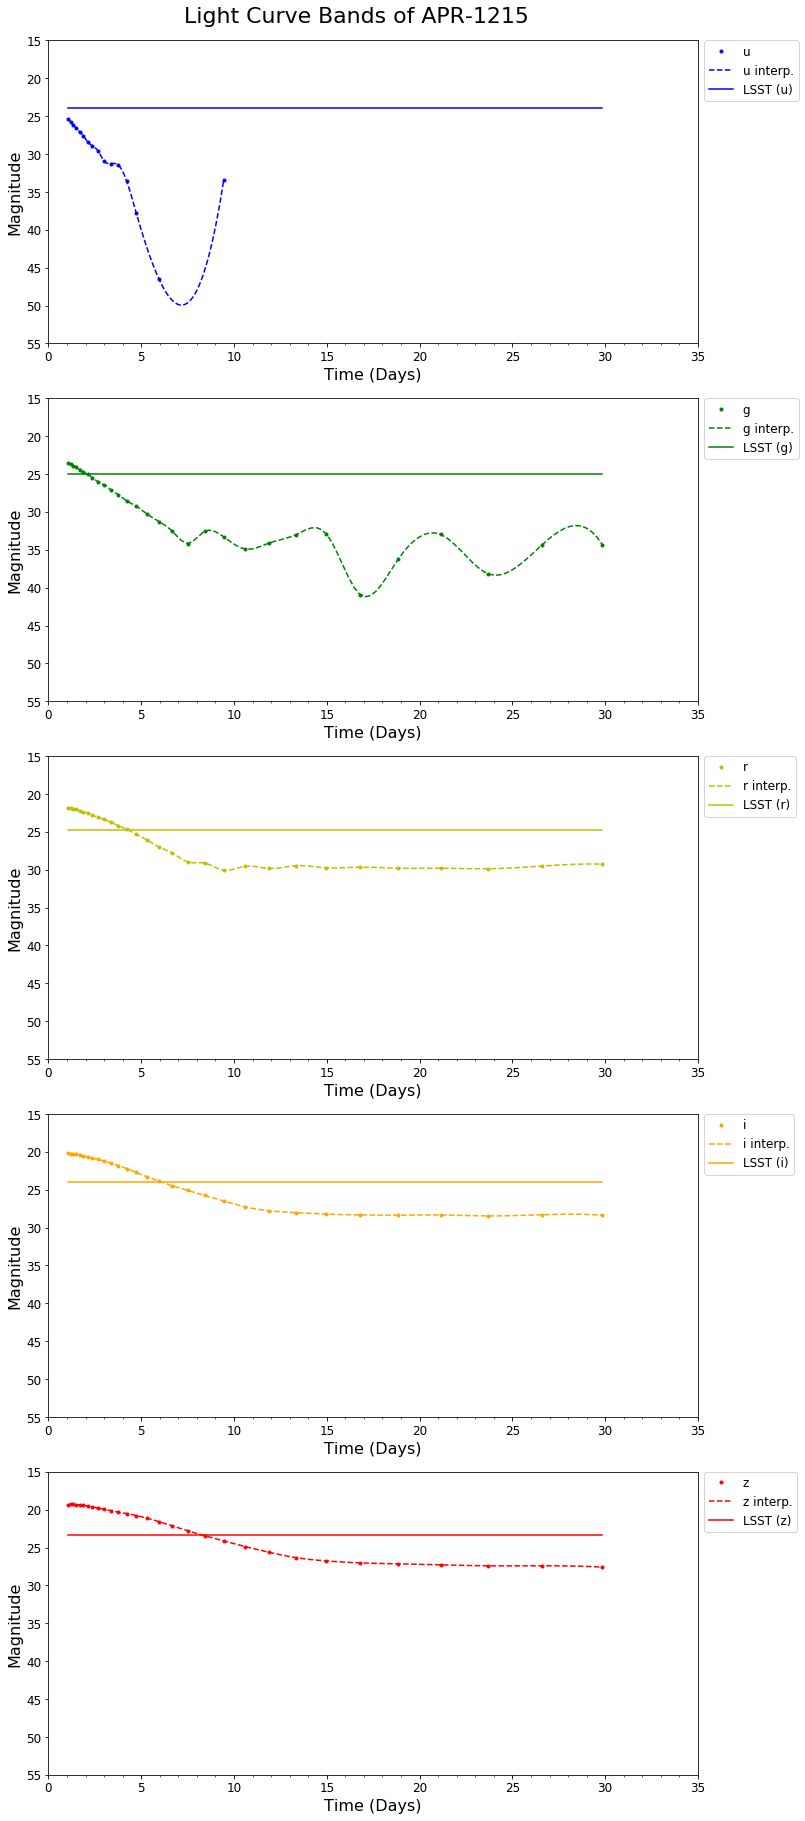

In [5]:
#The following are plots of only the data and the interpolations retrived from the data files in the ascii.reads, 
# converted into apparent magnitude.
full_plot(APR1215_app, "APR-1215")
plt.close()
band_plot(APR1215_app, "APR-1215")


In [6]:
full_plot(APR1314_app, "APR4-1314")
plt.close()
band_plot(APR1314_app, "APR4-1314")
plt.close()

In [7]:
full_plot(H41215_app, "H4-1215")
plt.close()
band_plot(H41215_app, "H4-1215")
plt.close()

In [8]:
full_plot(H41314_app, "H4-1314")
plt.close()
band_plot(H41314_app, "H4-1314")
plt.close()

In [9]:
full_plot(Sly135_app, "Sly-135")
plt.close()
band_plot(Sly135_app, "Sly-135")
plt.close()

### NS-BH Mergers (Apparent Magnitude)

In [10]:
#The following are plots of only the data and the interpolations retrived from the data files in the ascii.reads, 
# converted into apparent magnitude.
full_plot(APR4Q3a75_app, 'APR4Q3a75')
plt.close()
band_plot(APR4Q3a75_app, 'APR4Q3a75')
plt.close()

In [11]:
full_plot(H4Q3a75_app, 'H4Q3a75')
plt.close()
band_plot(H4Q3a75_app, 'H4Q3a75')
plt.close()

In [12]:
full_plot(MS1Q3a75_app, 'MS1Q3a75')
plt.close()
band_plot(MS1Q3a75_app, 'MS1Q3a75')
plt.close()

In [13]:
full_plot(MS1Q7a75_app, 'MS1Q7a75')
plt.close()
band_plot(MS1Q7a75_app, 'MS1Q7a75')
plt.close()

## Uncertainty Calculations

In [14]:
# Table of parameters necessary for uncertainty calculations
parameters = Table([['m_sky', 'theta', 'gamma', 'k_m', 'C_m', 'm_5', 'del_C', 'del_C2', 'del_m_5'],
                    [22.9, 0.77, 0.037, 0.451, 22.92, 23.68, 0.67, 0.24, 0.21],
                    [22.3, 0.73, 0.038, 0.163, 24.29, 24.89, 0.21, 0.09, 0.15],
                    [21.2, 0.70, 0.039, 0.087, 24.33, 24.43, 0.11, 0.05, 0.14],
                    [20.5, 0.67, 0.039, 0.065, 24.20, 24.00, 0.08, 0.04, 0.13], 
                    [19.6, 0.65, 0.040, 0.043, 24.07, 24.45, 0.05, 0.03, 0.13],
                    [18.6, 0.63, 0.040, 0.138, 23.69, 22.60, 0.04, 0.02, 0.15,]],
                  names = ('parameters','u', 'g', 'r', 'i', 'z', 'y'))

In [15]:
parameters

parameters,u,g,r,i,z,y
str7,float64,float64,float64,float64,float64,float64
m_sky,22.9,22.3,21.2,20.5,19.6,18.6
theta,0.77,0.73,0.7,0.67,0.65,0.63
gamma,0.037,0.038,0.039,0.039,0.04,0.04
k_m,0.451,0.163,0.087,0.065,0.043,0.138
C_m,22.92,24.29,24.33,24.2,24.07,23.69
m_5,23.68,24.89,24.43,24.0,24.45,22.6
del_C,0.67,0.21,0.11,0.08,0.05,0.04
del_C2,0.24,0.09,0.05,0.04,0.03,0.02
del_m_5,0.21,0.15,0.14,0.13,0.13,0.15


In [16]:
#Constants:
sigma_sys = 0.005
X = 1
t_vis = 30

In [142]:
import decimal

def sigma_1(mags, band):
    sigmas = []
    for mag in mags:
                sigma1 = np.float(np.sqrt(sigma_sys**2 + sigma_rand(mag, band, parameters)**2))
                sigmas.append(sigma1)
    return sigmas


def sigma_rand(mag, band, parameters):
    gamma = parameters[band][np.where(parameters['parameters']=='gamma')]
    return np.float((0.04-gamma)*x(mag, band, parameters) + gamma*x(mag, band, parameters)**2)

def x(mag, band, parameters):
    return np.float(10**(0.4*(mag-m_5(band, parameters, X, t_vis))))

def m_5(band, parameters, X=1, t_vis=30):
    C_m = parameters[band][np.where(parameters['parameters']=='C_m')]
    m_sky = parameters[band][np.where(parameters['parameters']=='m_sky')]
    theta = parameters[band][np.where(parameters['parameters']=='theta')]
    k_m = parameters[band][np.where(parameters['parameters']=='k_m')]
    m_5 = C_m+0.50*(m_sky-21)+2.5*np.log10(0.7/theta)+1.25*np.log10(t_vis/30)-k_m*(X-1)
    return np.float(m_5)

In [18]:
def sigma_plot(merger, name):
    fig = plt.figure(figsize=((10,25)))
    plot_sigmas(merger)
    #ax.axis([0,35,rounded_up(correct_max(merger))+5,(rounded_down(correct_min(merger))-5)])
    plt.suptitle("$\sigma$ Error of " + name, fontsize=title+5, y=1.01)
    plt.tight_layout()
    return


def plot_sigmas(merger):
    plot_sigma(merger, 'u', 0, 'blue', 511)
    plot_sigma(merger, 'g', 1, 'green', 512)
    plot_sigma(merger, 'r', 2, 'y', 513)
    plot_sigma(merger, 'i', 3, 'orange', 514)
    plot_sigma(merger, 'z', 4, 'red', 515)
    return

def plot_sigma(merger, band, number, color, placement):
    plt.subplot(placement)
    plt.plot(interpolate(merger)[number](day_new(merger, band)),
             sigma_1(interpolate(merger)[number](day_new(merger, band)), band),
             color=color, label='$\sigma_{'+band+'}$')
    plt.tick_params(labelsize=ticksize)
    plt.xlabel("Magnitude", fontsize=axis+5)
    plt.xlim(15,30)
    plt.ylim(0.001, 10)
    plt.yscale('log')
    plt.ylabel('$\sigma$', fontsize=axis+5)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend+5})

### NS-NS $\mathbf{\sigma}$ Plots

In [19]:
sigma_plot(APR1215_app, 'APR4-1215')
plt.close()

In [20]:
sigma_plot(APR1314_app, 'APR4-1314')
plt.close()

In [21]:
sigma_plot(H41215_app, "H4-1215")
plt.close()

In [22]:
sigma_plot(H41314_app, "H4-1314")
plt.close()

In [23]:
sigma_plot(Sly135_app, "Sly-135")
plt.close()

### NS-BH $\mathbf{\sigma}$ Plots

In [24]:
sigma_plot(APR4Q3a75_app, 'APR4Q3a75')
plt.close()

In [25]:
sigma_plot(H4Q3a75_app, 'H4Q3a75')
plt.close()

In [26]:
sigma_plot(MS1Q3a75_app, 'MS1Q3a75')
plt.close()

In [27]:
sigma_plot(MS1Q7a75_app, 'MS1Q7a75')
plt.close()

## Random Observation Light Curves

In [28]:
def rand_mags(merger):
    u = []
    g = []
    r = []
    i = []
    z = []
    days = merger['day']
    for day in days:
        u.append(rand_mag(merger, 'u', day, 0))        
        g.append(rand_mag(merger, 'g', day, 1))        
        r.append(rand_mag(merger, 'r', day, 2))       
        i.append(rand_mag(merger, 'i', day, 3))       
        z.append(rand_mag(merger, 'z', day, 4))
    return Table([days, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))

def rand_mag(merger, band, day, number):
    m_true = []
    m_true.append(interpolate(merger)[number](day))
    stdev = sigma_1(m_true, band)
    m_obs = np.random.normal(m_true, stdev)
    return np.float(m_obs)

def obs_sigmas(merger):
    u = sigma_1(merger['u'], 'u')
    g = sigma_1(merger['g'], 'g')
    r = sigma_1(merger['r'], 'r')
    i = sigma_1(merger['i'], 'i')
    z = sigma_1(merger['z'], 'z')
    return Table([u, g, r, i, z], names=('u-sig', 'g-sig', 'r-sig', 'i-sig', 'z-sig'))

In [29]:
#NS-NS Magnitudes

In [30]:
APR1215_rand = rand_mags(APR1215_app)
APR1314_rand = rand_mags(APR1314_app)
H41215_rand = rand_mags(H41215_app)
H41314_rand = rand_mags(H41314_app)
Sly135_rand = rand_mags(Sly135_app)

In [31]:
#NS-BH Magnitudes

In [32]:
APR4Q3a75_rand = rand_mags(APR4Q3a75_app)
H4Q3a75_rand = rand_mags(H4Q3a75_app)
MS1Q3a75_rand = rand_mags(MS1Q3a75_app)
MS1Q7a75_rand = rand_mags(MS1Q7a75_app)

In [185]:
def uplim_mags(merger, band):
    limits=[]
    regular=[]
    for mag in merger[band]:
        if mag > m_5(band, parameters):
            limits.append(mag)
        else:
            regular.append(mag)
    return {'regular': regular, 'limits': limits}


def uplim_days(merger, band):
    days_lims = []
    days_regs = []
    for x in uplim_mags(merger, band)['limits']:
        days_lims.append(merger[np.where(merger[band] == x)]['day'])
    for x in uplim_mags(merger, band)['regular']:
        days_regs.append(merger[np.where(merger[band] == x)]['day'])
    return {'regular': days_regs, 'limits': days_lims}

#rand_plot: Merger String String String -> Image
#Plots a randomly chosen band from the merger.
def band_plot_rand(merger, merger1, name):
    LSST_u=(merger['day']/merger['day'])-1+m_5('u', parameters, X, t_vis)
    LSST_g=(merger['day']/merger['day'])-1+m_5('g', parameters, X, t_vis)
    LSST_r=(merger['day']/merger['day'])-1+m_5('r', parameters, X, t_vis)
    LSST_i=(merger['day']/merger['day'])-1+m_5('i', parameters, X, t_vis)
    LSST_z=(merger['day']/merger['day'])-1+m_5('z', parameters, X, t_vis)
    fig=plt.figure(figsize=(12,30))
    for band in bands:
        if band == 'u':
            band_graph_rand(merger, 'u', 'b', 511, 0, LSST_u, merger1)
        elif band == 'g':
            band_graph_rand(merger, 'g', 'g', 512, 1, LSST_g, merger1)
        elif band == 'r':
            band_graph_rand(merger, 'r', 'y', 513, 2, LSST_r, merger1)
        elif band == 'i':
            band_graph_rand(merger, 'i', 'orange', 514, 3, LSST_i, merger1)
        elif band == 'z':
            band_graph_rand(merger, 'z', 'r', 515, 4, LSST_z, merger1)
    plt.suptitle("Light Curve Bands of " + name, fontsize=title, y=1.01)
    plt.tight_layout()
    return

def band_graph_rand(merger, band, color, sub_num, num, LSST_band, merger1):
    ax = plt.subplot(sub_num)
    plot_band_rand(merger, band, '.', color)
    plot_interp(merger1, band, '-', color, num)
    plt.plot(merger['day'], LSST_band, color, label='LSST (' + band + ')')
    plt.xlim(0,35)
    plt.ylim((rounded_up(correct_max(merger1))+5),(rounded_down(correct_min(merger1))-5))
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.xlabel("Time (Days)", fontsize=axis)
    plt.ylabel('Magnitude', fontsize=axis)
    ax.tick_params(labelsize=ticksize)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    return

#plot_band: Merger String String String -> Image
#Plots the magnitudes of a photometric band in the merger.
def plot_band_rand(merger, band, style, color):
    plt.errorbar(uplim_days(merger, band)['regular'], uplim_mags(merger, band)['regular'],
                 yerr=sigma_1(uplim_mags(merger, band)['regular'], band), fmt='.',
                 color=color, markeredgecolor='black', capsize = 5, label=band)
    
    plt.errorbar(uplim_days(merger, band)['limits'], limits(uplim_mags(merger, band)['limits'], band),
                 yerr=sigma_1(limits(uplim_mags(merger, band)['limits'], band), band), fmt='none', uplims=True,
                 color=color, markeredgecolor='black', capsize = 5, label=band+' limits')
    return

def limits(mags, band):
    mags_new = []
    for mag in mags:
        mags_new.append(m_5(band, parameters))
    return mags_new

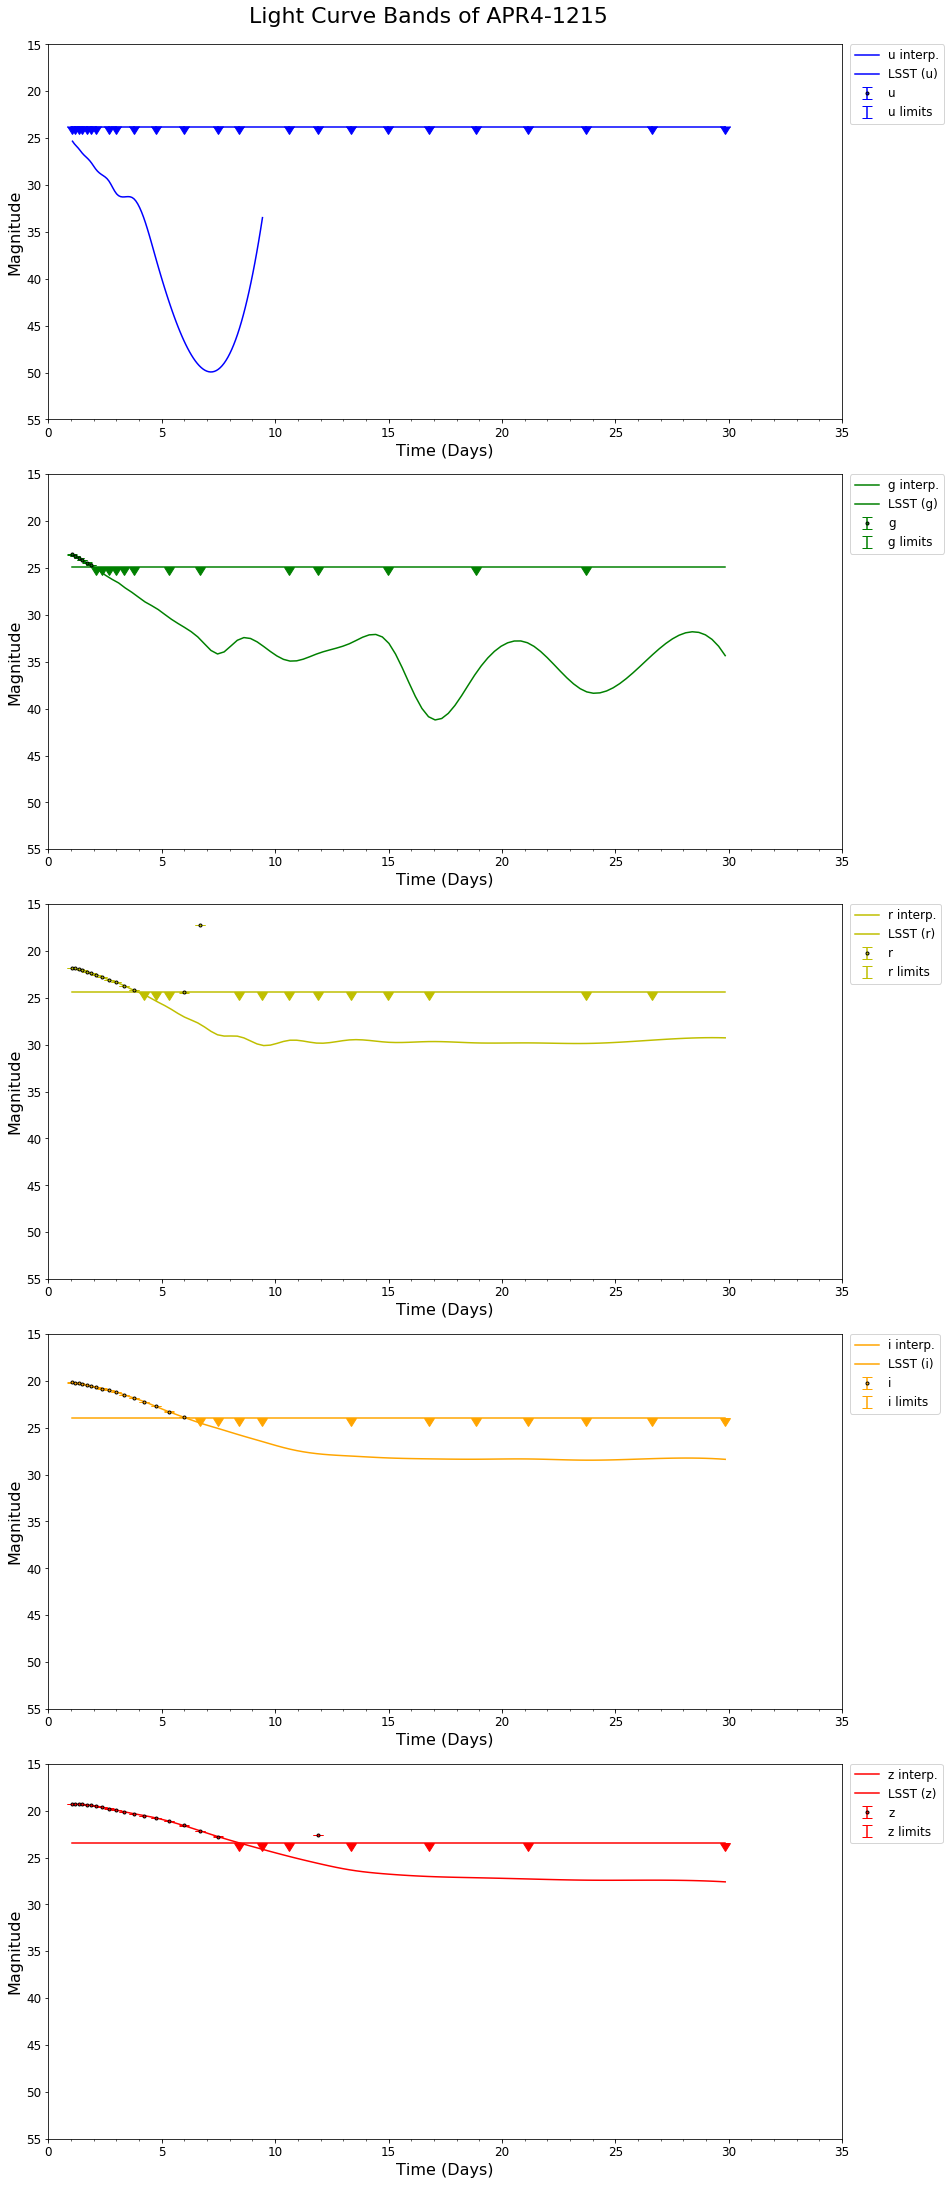

In [186]:
band_plot_rand(APR1215_rand, APR1215_app, 'APR4-1215')

In [201]:
band_plot_rand(APR1314_rand, APR1314_app, 'APR4-1314')
plt.close()

In [200]:
band_plot_rand(H41215_rand, H41215_app, 'H4-1215')
plt.close()

In [199]:
band_plot_rand(H41314_rand, H41314_app, 'H4-1314')
plt.close()

In [198]:
band_plot_rand(Sly135_rand, Sly135_app, 'Sly-135')
plt.close()

In [197]:
band_plot_rand(APR4Q3a75_rand, APR4Q3a75_app, 'APR4Q3a75')
plt.close()

In [196]:
band_plot_rand(H4Q3a75_rand, H4Q3a75_app, 'H4Q3a75')
plt.close()

In [195]:
band_plot_rand(MS1Q3a75_rand, MS1Q3a75_app, 'MS1Q3a75')
plt.close()

In [194]:
band_plot_rand(MS1Q7a75_rand, MS1Q7a75_app, 'MS1Q7a75')
plt.close()